In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from mixed_naive_bayes import MixedNB


from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.random import set_seed
set_seed(232)


## Data Loading

In [2]:
data = pd.read_csv("air_training.csv")
data.head(1)

,id,Gender,Customer.Type,Age,Type.of.Travel,Class,Flight.Distance,Inflight.wifi.service,Departure.Arrival.time.convenient,Ease.of.Online.booking,...,Inflight.entertainment,On.board.service,Leg.room.service,Baggage.handling,Checkin.service,Inflight.service,Cleanliness,Departure.Delay.in.Minutes,Arrival.Delay.in.Minutes,satisfaction
0,1,Female,Loyal Customer,56,Business travel,Business,632,2,2,2,...,4,4,5,4,5,4,3,0,0.0,satisfied


In [3]:
#l3fts check for the info about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 40000 non-null  int64  
 1   Gender                             40000 non-null  object 
 2   Customer.Type                      40000 non-null  object 
 3   Age                                40000 non-null  int64  
 4   Type.of.Travel                     40000 non-null  object 
 5   Class                              40000 non-null  object 
 6   Flight.Distance                    40000 non-null  int64  
 7   Inflight.wifi.service              40000 non-null  int64  
 8   Departure.Arrival.time.convenient  40000 non-null  int64  
 9   Ease.of.Online.booking             40000 non-null  int64  
 10  Gate.location                      40000 non-null  int64  
 11  Food.and.drink                     40000 non-null  int

## Data Cleaning

In [4]:
data.isnull().sum() 

# ok so we have some missing values in Arrival.Delay.in

id                                     0
Gender                                 0
Customer.Type                          0
Age                                    0
Type.of.Travel                         0
Class                                  0
Flight.Distance                        0
Inflight.wifi.service                  0
Departure.Arrival.time.convenient      0
Ease.of.Online.booking                 0
Gate.location                          0
Food.and.drink                         0
Online.boarding                        0
Seat.comfort                           0
Inflight.entertainment                 0
On.board.service                       0
Leg.room.service                       0
Baggage.handling                       0
Checkin.service                        0
Inflight.service                       0
Cleanliness                            0
Departure.Delay.in.Minutes             0
Arrival.Delay.in.Minutes             123
satisfaction                           0
dtype: int64

In [5]:
data.describe()
# the distributtion doesnt change much, d=so dropping the data was good

,id,Age,Flight.Distance,Inflight.wifi.service,Departure.Arrival.time.convenient,Ease.of.Online.booking,Gate.location,Food.and.drink,Online.boarding,Seat.comfort,Inflight.entertainment,On.board.service,Leg.room.service,Baggage.handling,Checkin.service,Inflight.service,Cleanliness,Departure.Delay.in.Minutes,Arrival.Delay.in.Minutes
count,40000.00000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,39877.000000
mean,20000.50000,39.321675,1183.097325,2.730175,3.055050,2.760325,2.978650,3.209800,3.247200,3.441000,3.363075,3.380500,3.352825,3.631175,3.299375,3.639200,3.292550,14.976675,15.295459
std,11547.14972,15.124509,992.822081,1.325467,1.523918,1.395503,1.272806,1.324794,1.349995,1.314025,1.327891,1.290276,1.316713,1.182192,1.268046,1.175716,1.308953,39.519878,39.788035
min,1.00000,7.000000,31.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,10000.75000,27.000000,413.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,20000.50000,40.000000,841.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,30000.25000,51.000000,1727.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,40000.00000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1305.000000,1280.000000


# Data Analysis

In [6]:
data.groupby('satisfaction').mean()

,id,Age,Flight.Distance,Inflight.wifi.service,Departure.Arrival.time.convenient,Ease.of.Online.booking,Gate.location,Food.and.drink,Online.boarding,Seat.comfort,Inflight.entertainment,On.board.service,Leg.room.service,Baggage.handling,Checkin.service,Inflight.service,Cleanliness,Departure.Delay.in.Minutes,Arrival.Delay.in.Minutes
satisfaction,,,,,,,,,,,,,,,,,,,
neutral or dissatisfied,19987.856923,37.527713,916.159234,2.405811,3.122782,2.552807,2.981686,2.968479,2.662822,3.041999,2.904733,3.023509,2.994101,3.376976,3.033326,3.386969,2.948492,16.788422,17.350811
satisfied,20017.114839,41.679202,1533.892739,3.156436,2.966040,3.033034,2.974660,3.526931,4.015158,3.965346,3.965404,3.849638,3.824241,3.965230,3.649002,3.970668,3.744692,12.595777,12.596125


In [7]:
#check for highly correlating features
data.corr()

,id,Age,Flight.Distance,Inflight.wifi.service,Departure.Arrival.time.convenient,Ease.of.Online.booking,Gate.location,Food.and.drink,Online.boarding,Seat.comfort,Inflight.entertainment,On.board.service,Leg.room.service,Baggage.handling,Checkin.service,Inflight.service,Cleanliness,Departure.Delay.in.Minutes,Arrival.Delay.in.Minutes
id,1.000000,-0.000158,-0.000984,0.001879,0.002843,0.001362,0.003058,0.001793,0.002106,-0.004660,-0.001109,0.002930,0.003319,0.002381,-0.003457,-0.000151,-0.000183,-0.000389,-0.003545
Age,-0.000158,1.000000,0.098589,0.022041,0.029462,0.026180,-0.001799,0.024549,0.207796,0.156409,0.076114,0.061158,0.042334,-0.042403,0.032690,-0.048066,0.050778,-0.012186,-0.014385
Flight.Distance,-0.000984,0.098589,1.000000,0.008300,-0.020752,0.069379,0.003154,0.057954,0.220629,0.160120,0.128790,0.110840,0.132953,0.065021,0.079384,0.060226,0.096407,0.002158,-0.003091
Inflight.wifi.service,0.001879,0.022041,0.008300,1.000000,0.344581,0.716882,0.337467,0.137269,0.462981,0.126700,0.209480,0.113639,0.160955,0.118645,0.042469,0.107276,0.133831,-0.019318,-0.020388
Departure.Arrival.time.convenient,0.002843,0.029462,-0.020752,0.344581,1.000000,0.438553,0.445607,0.001301,0.068717,0.003432,-0.010409,0.066449,0.012249,0.077298,0.091026,0.070919,0.006364,-0.004715,-0.005928
Ease.of.Online.booking,0.001362,0.026180,0.069379,0.716882,0.438553,1.000000,0.458451,0.031459,0.409752,0.031710,0.047757,0.034016,0.107902,0.038144,0.011813,0.037104,0.015311,-0.010729,-0.012146
Gate.location,0.003058,-0.001799,0.003154,0.337467,0.445607,0.458451,1.000000,-0.002488,-0.000842,0.000517,0.001835,-0.034923,-0.013615,0.005184,-0.038668,-0.003327,-0.005119,-0.002154,-0.002536
Food.and.drink,0.001793,0.024549,0.057954,0.137269,0.001301,0.031459,-0.002488,1.000000,0.237409,0.572565,0.619040,0.055225,0.034685,0.033078,0.093976,0.029724,0.659842,-0.033354,-0.034473
Online.boarding,0.002106,0.207796,0.220629,0.462981,0.068717,0.409752,-0.000842,0.237409,1.000000,0.419269,0.283511,0.146350,0.123013,0.080094,0.201450,0.073962,0.331307,-0.018275,-0.020192
Seat.comfort,-0.004660,0.156409,0.160120,0.126700,0.003432,0.031710,0.000517,0.572565,0.419269,1.000000,0.607382,0.131354,0.108533,0.078893,0.197846,0.069706,0.677277,-0.025494,-0.027155


In [8]:
data[['Arrival.Delay.in.Minutes', 'Departure.Delay.in.Minutes', 'Flight.Distance']].corr()

#it seems Arrival.delays might be highly correlllated with departure delays , whic makes sense , we might want to put just one of the features in the data

,Arrival.Delay.in.Minutes,Departure.Delay.in.Minutes,Flight.Distance
Arrival.Delay.in.Minutes,1.000000,0.968921,-0.003091
Departure.Delay.in.Minutes,0.968921,1.000000,0.002158
Flight.Distance,-0.003091,0.002158,1.000000


In [9]:
#lets check for what the distribution of the arrival time is and compare with the distribution of the Departure
data.groupby('satisfaction').describe()['Arrival.Delay.in.Minutes']

,count,mean,std,min,25%,50%,75%,max
satisfaction,,,,,,,,
neutral or dissatisfied,22639.0,17.350811,41.434443,0.0,0.0,0.0,17.0,952.0
satisfied,17238.0,12.596125,37.345922,0.0,0.0,0.0,8.0,1280.0


In [10]:
#lets check for what the distribution of the arrival time is and compare with the distribution of the Departure
data.groupby('satisfaction').describe()['Departure.Delay.in.Minutes']

#makes sense that they are truly close in distribution also

,count,mean,std,min,25%,50%,75%,max
satisfaction,,,,,,,,
neutral or dissatisfied,22715.0,16.788422,41.330607,0.0,0.0,0.0,16.0,930.0
satisfied,17285.0,12.595777,36.871901,0.0,0.0,0.0,9.0,1305.0


In [11]:
#lets drop id cos we can see its a just a bunch of random numbers and Arrival delay, since its highly correlated with arrival departure and it contains missing data 
data = data.drop(["id", "Arrival.Delay.in.Minutes"], axis=1)

<ipython-input-12-877dff91f7c9>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


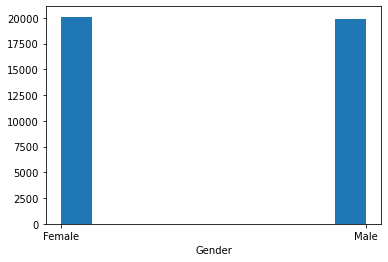

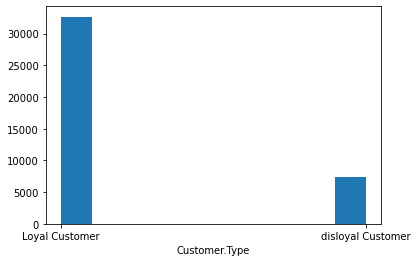

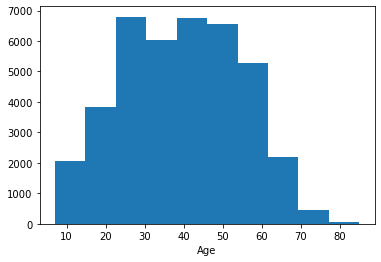

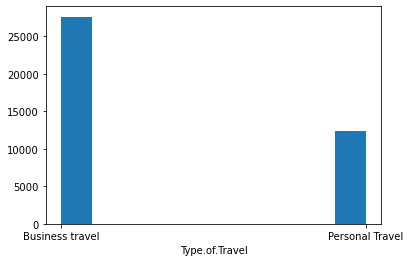

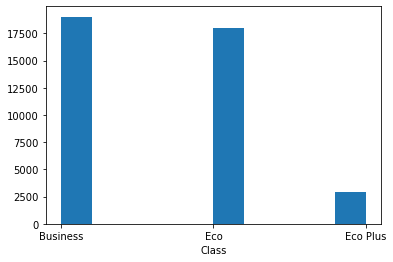

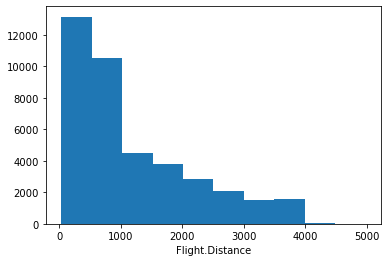

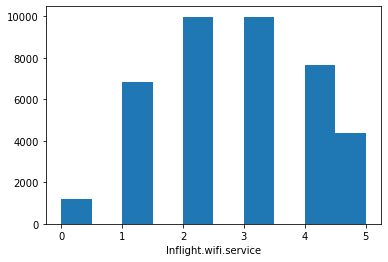

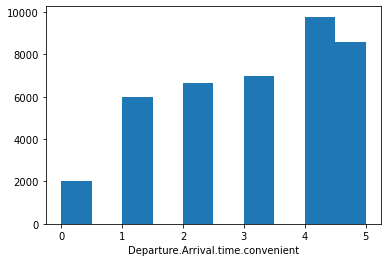

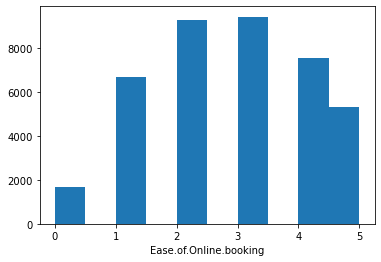

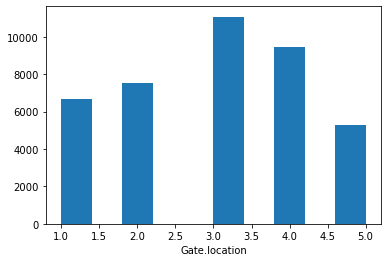

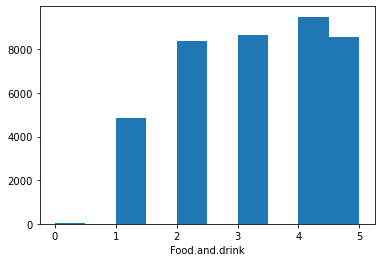

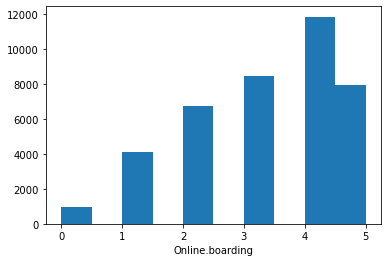

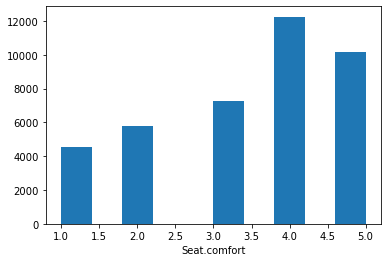

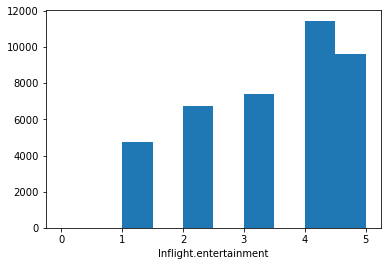

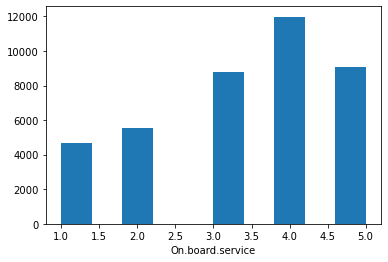

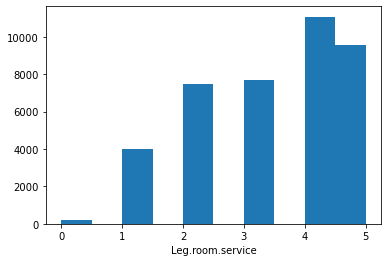

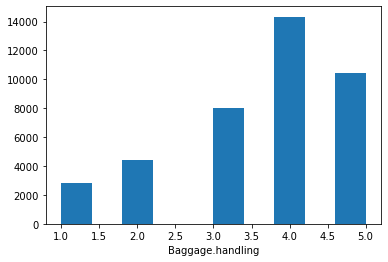

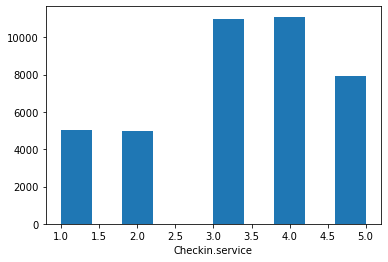

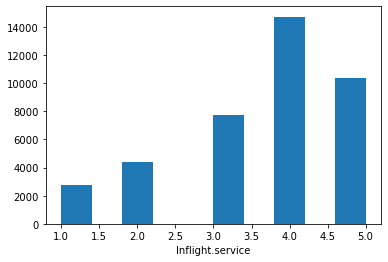

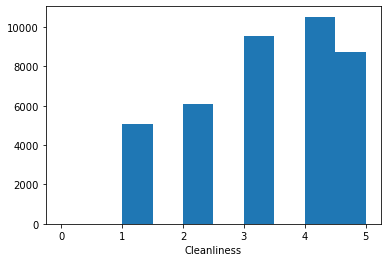

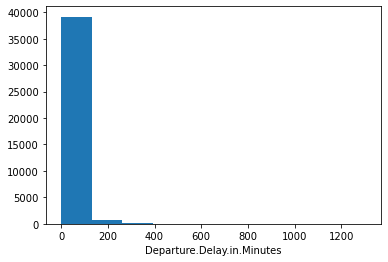

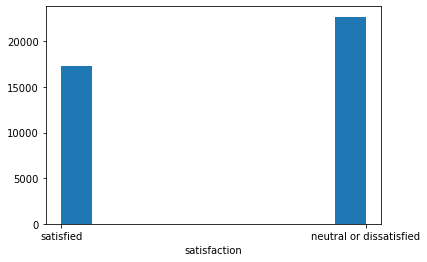

In [12]:
#check the distribution of our data
for i in data.columns:
    plt.figure(i)
    plt.hist(data[i])
    plt.xlabel(i)


In [13]:
#make a copy of the data 
df = data.copy()
df.head()

,Gender,Customer.Type,Age,Type.of.Travel,Class,Flight.Distance,Inflight.wifi.service,Departure.Arrival.time.convenient,Ease.of.Online.booking,Gate.location,...,Seat.comfort,Inflight.entertainment,On.board.service,Leg.room.service,Baggage.handling,Checkin.service,Inflight.service,Cleanliness,Departure.Delay.in.Minutes,satisfaction
0,Female,Loyal Customer,56,Business travel,Business,632,2,2,2,2,...,4,4,4,5,4,5,4,3,0,satisfied
1,Male,Loyal Customer,49,Business travel,Eco,544,3,1,1,1,...,3,3,1,5,4,5,5,3,0,satisfied
2,Male,Loyal Customer,58,Personal Travel,Eco,617,3,0,3,3,...,2,2,4,3,5,4,4,2,0,neutral or dissatisfied
3,Male,Loyal Customer,53,Business travel,Business,2210,1,1,1,1,...,4,4,4,4,4,3,4,5,0,satisfied
4,Male,disloyal Customer,25,Business travel,Eco,604,3,4,2,2,...,1,1,4,1,1,5,4,1,97,neutral or dissatisfied


# Data Training

In [14]:
# Encode the first column to be categorical
df['satisfaction'] = LabelEncoder().fit_transform(df['satisfaction']) 

In [15]:
X = df.drop(["satisfaction"], axis=1)
y = df['satisfaction']
X.head()

,Gender,Customer.Type,Age,Type.of.Travel,Class,Flight.Distance,Inflight.wifi.service,Departure.Arrival.time.convenient,Ease.of.Online.booking,Gate.location,...,Online.boarding,Seat.comfort,Inflight.entertainment,On.board.service,Leg.room.service,Baggage.handling,Checkin.service,Inflight.service,Cleanliness,Departure.Delay.in.Minutes
0,Female,Loyal Customer,56,Business travel,Business,632,2,2,2,2,...,4,4,4,4,5,4,5,4,3,0
1,Male,Loyal Customer,49,Business travel,Eco,544,3,1,1,1,...,3,3,3,1,5,4,5,5,3,0
2,Male,Loyal Customer,58,Personal Travel,Eco,617,3,0,3,3,...,3,2,2,4,3,5,4,4,2,0
3,Male,Loyal Customer,53,Business travel,Business,2210,1,1,1,1,...,5,4,4,4,4,4,3,4,5,0
4,Male,disloyal Customer,25,Business travel,Eco,604,3,4,2,2,...,2,1,1,4,1,1,5,4,1,97


In [16]:
#lets look for the number of numberical and caterogical features in data

# Numerical features in data
Num_features = []
for column in X.columns:
    if (df[column].dtype=='float64' or df[column].dtype=='int64'):
        Num_features.append(column)
    
# Categorical features in data
Cat_features = []
for column in X.columns:
    if (df[column].dtype=='object'):
        Cat_features.append(column)

print("Number of numerical features are: ",len(Num_features),'and the number of categorical features are:',len(Cat_features
                                                                                                                    ))

Number of numerical features are:  17 and the number of categorical features are: 4


In [17]:
X_num = X[Num_features]
X_num.shape

(40000, 17)

In [115]:
X[Cat_features]

X_cat = pd.get_dummies(X[Cat_features], drop_first= True)
X_cat.shape

(63717, 5)

# The Naive Bayes Model

In [19]:
# Transform the Departure.Delay.in.Minutes features to more normally distributed
X_num['Departure.Delay.in.Minutes'] = np.log(1 + X_num['Departure.Delay.in.Minutes'])

<ipython-input-19-faa73d348ec7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_num['Departure.Delay.in.Minutes'] = np.log(1 + X_num['Departure.Delay.in.Minutes'])


In [20]:
# First combine the numerical and categorical features
fullX = pd.concat([X_num,X_cat], axis = 1)

# Mixed Naive Bayes
X_train, X_test, y_train, y_test = train_test_split(fullX, y, test_size = 0.2, random_state = 862)

# Mixed Naive Bayes
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 862)

MNB = MixedNB(categorical_features = range(X_num.shape[1], fullX.shape[1]))

#test set
MNB.fit(X_train_train, y_train_train)

#validation set 
np.mean(MNB.predict(X_val) == y_val)

# now test train and test on the full dataset
MNB.fit(X_train, y_train)

print(MNB.predict(X_test))
print(np.mean(MNB.predict(X_test) == y_test))

[2 2 2 2 2]
[2 2 2 2 2]
[0 0 0 ... 0 0 1]
0.8525


#Naive Bayes wont be a good predictive model for this data set

# SVM Training

In [21]:
# First combine the numerical and categorical features
fullX.shape

(40000, 22)

In [22]:
# Split our dataset

X_train, X_test, y_train, y_test = train_test_split(fullX, y, test_size = 0.2, random_state = 862)

In [23]:
from sklearn.svm import LinearSVC


# Classifier
svm_clf = Pipeline([('scalar', StandardScaler()),
                    ('linear_svc', LinearSVC(loss = "hinge", random_state = 862))
                    ])

parameters = {'linear_svc__C':[0.1, 0.2, 0.3, 0.4, 0.5,1,10]}
svm_linear = GridSearchCV(svm_clf, parameters, cv=5, n_jobs = -1)
svm_linear.fit(X_train, y_train) 

# Evaluation on test set
np.mean(svm_linear.predict(X_test) == y_test)

C:\Users\bomia\anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.880125

In [24]:
svm_linear.best_params_

{'linear_svc__C': 0.5}

In [73]:
#using the different kernels to choose the best SVM for tunning the data
#1st we used the linear kernel

from sklearn.svm import SVC

linear_svm_clf = Pipeline([('scaler', StandardScaler()),
                            ('svm_clf', SVC(kernel="linear", random_state = 862))
                               ])
parameters = {'svm_clf__C' : [ 0.01,1,10]}
linear_clf = GridSearchCV(linear_svm_clf, parameters, cv= 5, n_jobs=-1)
linear_clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm_clf',
                                        SVC(kernel='linear',
                                            random_state=862))]),
             n_jobs=-1, param_grid={'svm_clf__C': [0.01, 1, 10]})

In [ ]:
linear_clf.best_params_

In [ ]:
# Polynomial kernel
poly_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel="poly", random_state = 862))
])
parameters = {'svm_clf__C' : [ 0.1, 1,10],
             'svm_clf__degree': [1,2, 3],
             'svm_clf__coef0': [0,1]}
poly_clf = GridSearchCV(poly_svm_clf, parameters, cv=10, n_jobs=-1)
poly_clf.fit(X_train, y_train)

In [114]:
# We will use the RBF kernel for this classification

rbf_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel="rbf", random_state = 862))
])
parameters = {'svm_clf__C': [0.01, 0.1,1, 2],
             'svm_clf__gamma': [0.1,1]}
rbf_clf = GridSearchCV(rbf_clf, parameters, cv = 5, n_jobs = -1)
rbf_clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm_clf', SVC(random_state=862))]),
             n_jobs=-1,
             param_grid={'svm_clf__C': [0.01, 0.1, 1, 2],
                         'svm_clf__gamma': [0.1, 1]})

In [ ]:
print(svm_linear.best_params_)
print(linear_clf.best_params_)
print(poly_clf.best_params_)
print(rbf_clf.best_params_)
#not a linear kernel is not tuning great, so the poly kernel or rbf might be better predictors

In [ ]:
print(np.mean(linear_clf.predict(X_test) == y_test))

In [ ]:
# Let's just compare the prediction accuracy of the three models
print(np.mean(svm_linear.predict(X_test) == y_test))
print(np.mean(linear_clf.predict(X_test) == y_test))
print(np.mean(poly_clf.predict(X_test) == y_test))
print(np.mean(rbf_clf.predict(X_test) == y_test))

### Test for Svm_linear : 0.878875

### Testing for linear_kernel  : 0.878625

### Testing for poly_kernel : :0.95

### Testing for rbf_kernel : 0.951625
    
## we can see the rbf gives a much better prediction

In [ ]:
#Just to check our results for overfiiting we would check the results on the training sets

# Let's just compare the prediction accuracy of the three models
print(np.mean(svm_linear.predict(X_train) == y_train))
print(np.mean(linear_clf.predict(X_train) == y_train))
print(np.mean(poly_clf.predict(X_train) == y_train))
print(np.mean(rbf_clf.predict(X_train) == y_train))

# Neural Network

In [27]:
X_trained, X_valid, y_trained, y_valid = train_test_split(X_train, y_train,
                                                      test_size = 0.15, random_state = 908)

In [28]:
# Scale data
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_train_s = scale.fit_transform(X_trained)
X_valid_s = scale.transform(X_valid)


In [29]:

def build_model(n_hidden = 1, n_neurons = 30, learning_rate = 0.001, input_dim = 22):
    model = Sequential() # Instantiate the model
    options = {"input_dim": input_dim} # Set options 
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation = 'relu', **options)) # Here we are using the input options from before
        options = {} # Now we erase the input options so it won't be included in future layers
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = tf.keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'binary_crossentropy', metrics = 'accuracy', optimizer = optimizer)
    return model

keras_cls = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model) 
from sklearn.model_selection import GridSearchCV

param = {'n_hidden': [1,2,3],
        'n_neurons':[10,20,30,100], #defining range of neurons
        'learning_rate':[0.1, 0.01, 0.001]}  #range of learning rates

grd_cv = GridSearchCV(keras_cls, param, cv = 2, n_jobs = -1)



grd_cv.fit(X_train_s, y_trained, epochs = 100,
          validation_data = (X_valid_s, y_valid),
          callbacks = tf.keras.callbacks.EarlyStopping(patience=3))

Epoch 1/100
850/850 [==============================] - 2s 2ms/step - loss: 0.2290 - accuracy: 0.9079 - val_loss: 0.1792 - val_accuracy: 0.9277
Epoch 2/100
850/850 [==============================] - 1s 2ms/step - loss: 0.1623 - accuracy: 0.9343 - val_loss: 0.1576 - val_accuracy: 0.9344
Epoch 3/100
850/850 [==============================] - 2s 2ms/step - loss: 0.1404 - accuracy: 0.9419 - val_loss: 0.1489 - val_accuracy: 0.9390
Epoch 4/100
850/850 [==============================] - 2s 2ms/step - loss: 0.1265 - accuracy: 0.9482 - val_loss: 0.1376 - val_accuracy: 0.9433
Epoch 5/100
850/850 [==============================] - 1s 1ms/step - loss: 0.1182 - accuracy: 0.9507 - val_loss: 0.1316 - val_accuracy: 0.9475
Epoch 6/100
850/850 [==============================] - 2s 2ms/step - loss: 0.1082 - accuracy: 0.9549 - val_loss: 0.1302 - val_accuracy: 0.9479
Epoch 7/100
850/850 [==============================] - 1s 1ms/step - loss: 0.1039 - accuracy: 0.9550 - val_loss: 0.1250 - val_accuracy: 0.9496

GridSearchCV(cv=2,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000019AE66ACD30>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'n_hidden': [1, 2, 3],
                         'n_neurons': [10, 20, 30, 100]})

In [30]:
keras_cls = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model) 


The Validation error seems to be reducing and stops at 0.122

But the Epoch stops at 12 iterartions , so mabe we shoudl go all the way to 100, but just incase


In [31]:
grd_cv.best_params_

{'learning_rate': 0.1, 'n_hidden': 3, 'n_neurons': 100}

In [32]:
accuracy_nn_val=np.mean(grd_cv.predict(X_valid_s ).reshape(1,X_valid_s.shape[0]) == np.array(y_valid))
print("Accuracy for Neural Network is:", accuracy_nn_val)

Accuracy for Neural Network is: 0.94875


# The Emsemble Model

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

In [35]:
estimator = Pipeline( [('scale', StandardScaler()),
                      ('clf', LogisticRegression(penalty = 'l1', solver = 'liblinear', random_state = 1))] )
logit_grid = {'clf__C': np.logspace(-2, 1, 20),
             'clf__penalty': ['l1', 'l2']}

lr = GridSearchCV(estimator, logit_grid, cv = 10, scoring = 'accuracy', n_jobs = -1)
lr.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(penalty='l1',
                                                           random_state=1,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'clf__C': array([ 0.01      ,  0.0143845 ,  0.02069138,  0.02976351,  0.04281332,
        0.06158482,  0.08858668,  0.1274275 ,  0.18329807,  0.26366509,
        0.37926902,  0.54555948,  0.78475997,  1.12883789,  1.62377674,
        2.33572147,  3.35981829,  4.83293024,  6.95192796, 10.        ]),
                         'clf__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [43]:
#lest obtain the best params for this losgistic  regression model to late use as a base for the Ada bost method
lr.best_params_


{'clf__C': 0.18329807108324356, 'clf__penalty': 'l2'}

In [36]:
# Prediction on test set
np.mean(lr.predict(X_test) == y_test)

0.878625

In [51]:
# Tune your tree with max_depth and max_leaf_nodes
grid = {'max_depth': np.arange(10, 31),
       'max_leaf_nodes': np.arange(20, 51)}

DT= GridSearchCV(DecisionTreeClassifier(random_state = 1),grid, 
                   cv = 5, scoring = 'accuracy', n_jobs = -1)
DT.fit(X_trainS, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30]),
                         'max_leaf_nodes': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             scoring='accuracy')

In [52]:
# Prediction on test set
np.mean(DT.predict(X_testS) == y_test)

0.93675

In [65]:
# Tuned for k to 100 but realised k = 5 was the best k value
estimator = Pipeline( [('scale', StandardScaler()),
                      ('clf', KNeighborsClassifier(n_neighbors = k, weights= 'uniform'))] )
logit_grid = {'clf__n_neighbors': range(1,10)}

knn = GridSearchCV(estimator, logit_grid, cv = 5, scoring = 'accuracy', n_jobs = -1)
knn.fit(X_train, y_train)


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('clf',
                                        KNeighborsClassifier(n_neighbors=99))]),
             n_jobs=-1, param_grid={'clf__n_neighbors': range(1, 100)},
             scoring='accuracy')

In [70]:
#it shows the best k for our knn is 

knn.best_params_

{'clf__n_neighbors': 5}

In [46]:
# Define the individual models
knn = KNeighborsClassifier(n_neighbors = 5, weights= 'uniform')


#we know thw rdf works better from tunning  earlei
svm = SVC(kernel = 'rbf', probability = True)

# Instantiate the classifier
vc = VotingClassifier(estimators = [('lr', lr),  ('DT', DT), 
                                   ('knn', knn), ('svm', svm)], n_jobs = 2, voting = 'soft')

# Scale the data
scaler = StandardScaler()
X_trainS = scaler.fit_transform(X_train)
X_testS = scaler.transform(X_test)

# Fit the model
vc.fit(X_trainS, y_train)

VotingClassifier(estimators=[('lr',
                              GridSearchCV(cv=10,
                                           estimator=Pipeline(steps=[('scale',
                                                                      StandardScaler()),
                                                                     ('clf',
                                                                      LogisticRegression(penalty='l1',
                                                                                         random_state=1,
                                                                                         solver='liblinear'))]),
                                           n_jobs=-1,
                                           param_grid={'clf__C': array([ 0.01      ,  0.0143845 ,  0.02069138,  0.02976351,  0.04281332,
        0.06158482,  0.08858668,  0.1274275 ,  0.18329807,  0.26366509,
        0.37926902,  0.54555948,  0.78...97,  1.12883789,  1.62377674,
        2.3357

In [47]:
# Prediction on test set
np.mean(vc.predict(X_testS) == y_test)

0.94775

Testing Accuracy for Logistics Regression : 0.878625

Testing Accuracy for Decision Tress : 0.93675

Testing Accuracy for  Soft Vocting : 0.94775



# using the stacking Method

In [99]:
# Also define the blender
from sklearn.svm import LinearSVR
blender = SVC(kernel="rbf", random_state = 862)

In [100]:
# First we will define the base learners. We will put them in a dictionary
models = {'lr': lr, 'DT': DT, 'knn': knn, 'svm': svm}

In [101]:
# Scale data
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_trainS = scale.fit_transform(X_train)

In [102]:
# Now split the training data into two parts, one to train the weak learners, another to train the blender
X_trainS1, X_trainS2, y_train1, y_train2 = train_test_split(X_trainS, y_train, 
                                                            test_size = 0.5, random_state = 908) 


In [103]:
#train weak learners
for name, model in models.items():
    model.fit(X_trainS1, y_train1)

In [104]:
# Train the blender
# Get the prediction
predictions = pd.DataFrame() # Set up a dataframe to store the predictions
for name, model in models.items():
    predictions[name] = model.predict(X_trainS2)

# Get the blender
scaler_blend = StandardScaler() # Scale the predictions for SVR
predictions_scale = scaler_blend.fit_transform(predictions)
blender.fit(predictions_scale, y_train2)

SVC(random_state=862)

In [106]:
# Perform evaluation
# First send the data through the weak learners
predictions = pd.DataFrame() # Set up a dataframe to store the predictions
for name, model in models.items():
    predictions[name] = model.predict(X_testS)
    
# Prediction through the blender, and evaluate
predictions_scale = scaler_blend.transform(predictions)
np.sqrt(mean_squared_error(blender.predict(predictions_scale), y_test))

0.23157072353818822

# Results

In [118]:
# Naives bayes
print(MNB.predict(X_test))
print(np.mean(MNB.predict(X_test) == y_test))

[0 0 0 ... 0 0 1]
0.8525


In [117]:
#svm - rbf

print(np.mean(rbf_clf.predict(X_test) == y_test))

0.95125


In [119]:
# neuron netwrk test set accuracy at 0.94875

accuracy_nn_val=np.mean(grd_cv.predict(X_valid_s ).reshape(1,X_valid_s.shape[0]) == np.array(y_valid))
print("Neural Network accuracy is:", accuracy_nn_val)

Accuracy for Neural Network is: 0.94875


In [120]:
# emsemble method

# Perform evaluation
# First send the data through the weak learners
predictions = pd.DataFrame() # Set up a dataframe to store the predictions
for name, model in models.items():
    predictions[name] = model.predict(X_testS)
    
# Prediction through the blender, and evaluate
predictions_scale = scaler_blend.transform(predictions)
np.sqrt(mean_squared_error(blender.predict(predictions_scale), y_test))

0.23157072353818822

# Using the test sets 

In [76]:
df1 = pd.read_csv("air_testing_withlabel.csv")
df1.shape

(63717, 24)

In [132]:
df1.describe()

#thast great, no null values

,id,Age,Flight.Distance,Inflight.wifi.service,Departure.Arrival.time.convenient,Ease.of.Online.booking,Gate.location,Food.and.drink,Online.boarding,Seat.comfort,Inflight.entertainment,On.board.service,Leg.room.service,Baggage.handling,Checkin.service,Inflight.service,Cleanliness,Departure.Delay.in.Minutes,Arrival.Delay.in.Minutes,satisfaction
count,63717.000000,63717.000000,63717.000000,63717.000000,63717.000000,63717.000000,63717.000000,63717.000000,63717.000000,63717.000000,63717.000000,63717.000000,63717.000000,63717.000000,63717.000000,63717.000000,63717.000000,63717.000000,63717.000000,63717.000000
mean,31859.000000,39.416341,1193.284649,2.729523,3.063594,2.754901,2.975988,3.197137,3.252507,3.438454,3.355227,3.384058,3.350189,3.632233,3.307171,3.641587,3.282201,14.655806,15.105592,0.434091
std,18393.657888,15.105904,1000.145743,1.329241,1.525807,1.400952,1.280619,1.332438,1.349116,1.322193,1.336290,1.287082,1.314797,1.180219,1.263685,1.175534,1.314352,37.315862,38.001164,0.495641
min,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15930.000000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,31859.000000,40.000000,844.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000
75%,47788.000000,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000,1.000000
max,63717.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000,1.000000


In [127]:
# Encode the first column to be categorical
df1['satisfaction'] = LabelEncoder().fit_transform(df1['satisfaction']) 


In [135]:
# Transform the Departure.Delay.in.Minutes features to more normally distributed
df1['Departure.Delay.in.Minutes'] = np.log(1 + df1['Departure.Delay.in.Minutes'])


X = df1.drop(["id", "Arrival.Delay.in.Minutes", "satisfaction"], axis=1)
y = df1['satisfaction']

#now we have our dataset ready for testing
X = pd.get_dummies(X, drop_first= True)
X.shape

(63717, 22)

# Using this cleaned data on our new test set

In [141]:
# Naives bayes

NB_new = MNB.predict(X)
print(np.mean(MNB.predict(X) == y))

# predictions seems to be the same as the earlier ran sets, guess we dint do a bad job on our training sets 

0.8516722381781942


In [137]:
#svm - rbf - the prediction on the new dataset, seems to be running great also
print(np.mean(rbf_clf.predict(X) == y))

0.9544077718662209


In [184]:
#NeuralNetwork
accuracy_nn_val=np.mean(grd_cv.predict(X).reshape(1,X.shape[0]) == np.array(y))
print("Accuracy for Neural Network is:", accuracy_nn_val)

#seems our neural netwrk dint do well on the new test set

Accuracy for Neural Network is: 0.4401651050739991


In [139]:
# emsemble method

# Perform evaluation
# First send the data through the weak learners
predictions = pd.DataFrame() # Set up a dataframe to store the predictions
for name, model in models.items():
    predictions[name] = model.predict(X)
    
# Prediction through the blender, and evaluate
predictions_scale = scaler_blend.transform(predictions)
np.sqrt(mean_squared_error(blender.predict(predictions_scale), y))

#seems we did better with the testing set

0.6588561093205796

In [166]:
#lets create a new geature for our prediction
df1['Rbf_SVM'] = pd.DataFrame(rbf_clf.predict(X))  
df1['NaivesBayes'] = pd.DataFrame(NB_new)  
df1['stacking'] = pd.DataFrame(model.predict(X))
df1['NeuralNetwrk'] = pd.DataFrame(grd_cv.predict(X))

In [183]:
New_df = df1[['id',  'Rbf_SVM', 'NeuralNetwrk', 'NaivesBayes', 'stacking']]
pd.DataFrame(New_df)

,id,Rbf_SVM,NeuralNetwrk,NaivesBayes,stacking
0,1,1,1,1,1
1,2,0,1,0,1
2,3,1,1,1,1
3,4,0,1,0,1
4,5,1,1,1,1
...,...,...,...,...,...
63712,63713,1,1,1,1
63713,63714,1,1,1,1
63714,63715,0,1,0,1
63715,63716,0,1,0,1


In [195]:
New_df = df1[[ 'Rbf_SVM', 'NeuralNetwrk', 'NaivesBayes', 'stacking']].replace([0, 1], ['neutral or dissatisfied', 'satisfied'])


In [194]:
# New dataframe obtained
Newdf = pd.concat([df1['id'], New_df], axis= 1)
Newdf

,id,Rbf_SVM,NeuralNetwrk,NaivesBayes,stacking
0,1,satisfied,satisfied,satisfied,satisfied
1,2,neutral or dissatisfied,satisfied,neutral or dissatisfied,satisfied
2,3,satisfied,satisfied,satisfied,satisfied
3,4,neutral or dissatisfied,satisfied,neutral or dissatisfied,satisfied
4,5,satisfied,satisfied,satisfied,satisfied
...,...,...,...,...,...
63712,63713,satisfied,satisfied,satisfied,satisfied
63713,63714,satisfied,satisfied,satisfied,satisfied
63714,63715,neutral or dissatisfied,satisfied,neutral or dissatisfied,satisfied
63715,63716,neutral or dissatisfied,satisfied,neutral or dissatisfied,satisfied


In [ ]:
# we can conclude that some models did way better than the ithers, but im glad we did this cos it shows we can put our modelling and porediction skills to see the results on realtime dataset